# Inference on custom data

In [ ]:
from fastMONAI.vision_all import *
from IPython.display import clear_output
from huggingface_hub import snapshot_download

In [ ]:
#Example data
DATA_DIR = Path('../data')
STUDY_DIR = download_example_spine_data(path=DATA_DIR)

In [ ]:
# Download the models from the study repository and load exported learners 
models_path = Path(snapshot_download(repo_id="skaliy/spine-segmentation",  cache_dir='models'))
learner_list = list(models_path.glob('*learner.pkl'))
loaded_learners = [load_learner(fn, cpu=True) for fn in learner_list]

In [ ]:
# Load variables
vars_fn = models_path/'vars.pkl'
_, reorder, resample = load_variables(pkl_fn=vars_fn)
reorder, resample

(True, [4.4, 0.78, 0.78])

In [ ]:
fn = str(STUDY_DIR/'img.nii.gz')
save_fn = fn.split('.nii')[0] + '_pred.nii.gz'

In [ ]:
#Predict with ensemble
mask_data = None

for learner in loaded_learners:
    mask = inference(learner, reorder, resample, fn)
    
    if mask_data is None: mask_data = torch.zeros_like(mask.data) ## Initialize a tensor of zeros for storing the mask data
    else: mask_data += mask.data # Add the mask data to the accumulated mask data

In [ ]:
# Average the accumulated mask data
mask_data /= len(loaded_learners)

# Threshold the averaged mask data to create a binary mask
mask_data = torch.where(mask_data > 0.5, 1., 0.)

# Apply postprocessing to remove small objects from the binary mask
mask_data = torch.Tensor(pred_postprocess(mask_data))

# Set the data of the mask object to the processed mask data
mask.set_data(mask_data)

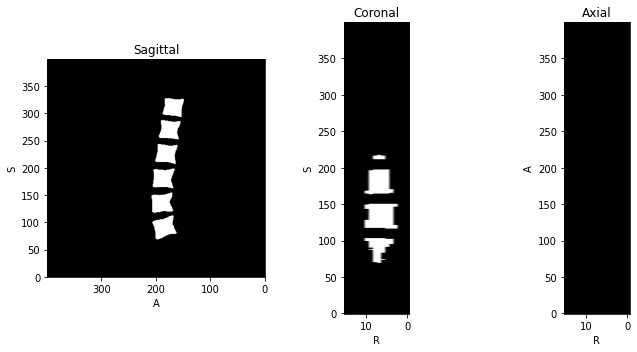

In [ ]:
mask.save(save_fn)
mask.plot(figsize=(10,5))